This notebook will introduce datasets.Dataset and torch dataloader to process batch data


In [228]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import random
from typing import List
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB

import torchaudio

import torch

from torch.utils.data import DataLoader,TensorDataset

import lightning as L

import datasets

from torch.utils.data import Dataset, DataLoader,WeightedRandomSampler

from pathlib import Path
import multiprocessing
import colorednoise as cn
import torch.nn as nn
import librosa

In [229]:
metadata_path='../../data/train_metadata_new_add_rating.csv'

In [230]:
# Need to interpolate missing values ​​for ratings in metadata csv file

def rating_value_interplote(df:pd.DataFrame):
    '''
    interplote Nan values for rating col in metadata csv 

    parameters:
        df: the df of the metadata csv file

    rating col means the quality of the corresponding audio file
        5 is high quality
        1 is low quality
        0 is without defined quality level
    '''

    if df['rating'].isna().sum()>0: # with missing value
        df['rating'].fillna(0, inplace=True)

    # Random assign a value to all places where the value is 0, and select from the specified choices
    mask = df['rating'] == 0  # Create a boolean mask indicating which positions are 0

    choices=np.arange(0.5,5.1,0.5).tolist() # [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
    random_values = np.random.choice(choices, size=mask.sum())  # Generate random numbers for these 0 values  
    df.loc[mask, 'rating'] = random_values  # Fill the generated random numbers back into the corresponding positions of the original DataFrame

    return df

In [231]:
# Calculate the weight of each audio file by rating, which helps model training
def audio_weight(df):
    '''
    calculate the weight corresponding to each audio file through the rating value

    Because each audio has different quality level, we use weight to affect the inportance of each audio in models,
    the lower the quality of the audio, the lower the weight
    '''
    df["audio_weight"] = np.clip(df["rating"] / df["rating"].max(), 0.1, 1.0)

    return df



In [232]:
# Because this is an unbalanced dataset, the amount of data in each category is very different
# So I will calculate the weight of each category here
# **(-0.5) The purpose is to reduce the relative influence of high-frequency categories and increase the influence of low-frequency categories, 
# so as to help the model better learn those uncommon categories
# The purpose of calculating this is to build a WeightedRandomSampler, so that each time a batch is extracted using dataloader, it is more friendly to data of different categories.
def sampling_weight(df)->torch.Tensor:
    '''
    calculate the sampling weight of each audio file

    because this is imbalanced dataset
    we hope the category with less data has large probability to be picked.
    '''
    sample_weights = (df['primary_label'].value_counts() / df['primary_label'].value_counts().sum()) ** (-0.5)

    # Map weights to each row of the original data
    sample_weights_map = df['primary_label'].map(sample_weights)

    # Convert pandas Series to NumPy array
    sample_weights_np = sample_weights_map.to_numpy(dtype=np.float32)

    # Convert a NumPy array to a PyTorch tensor using torch.from_numpy
    sample_weights_tensor = torch.from_numpy(sample_weights_np)

    return sample_weights_tensor


In [233]:
df=pd.read_csv(metadata_path,header=0)

sample_weights_tensor=sampling_weight(df=df)
# Here we will build an argument sampler that will be used by the dataloader
# It should be noted that the order of weights in the constructed sampler needs to be consistent with the order of data passed into the dataloader, otherwise the weights will not match

# Create a sampler based on the newly obtained weight list
sampler = WeightedRandomSampler(sample_weights_tensor.type('torch.DoubleTensor'), len(sample_weights_tensor),replacement=True)

sampler

In [234]:
def read_audio(path: str):
    """
    Read an OGG file using torchaudio and return the waveform tensor and sample rate.

    Parameters:
        path: Path to the .ogg file

    Returns:
        waveform: Tensor representing the waveform
        sample_rate: Sample rate of the audio file
    """
    audio, sample_rate = torchaudio.load(path)
    return audio, sample_rate


In [235]:
audio,sample_rate=read_audio(path='../../data/train/asbfly/XC134896.ogg')

print(audio)
print(audio.shape)
print(sample_rate)

tensor([[ 1.3738e-06,  9.2571e-07, -2.7169e-06,  ...,  6.2166e-06,
         -1.4831e-06, -3.4762e-06]])
torch.Size([1, 875207])
32000


In [236]:
class BirdclefDataset(Dataset):
    def __init__(self,metadata_path:str,audio_dir:str='../../data/train_audio'):
        '''
        parameters:
            metadata_path: the directory of the metadata csv file
            audio_dir: the parent path where all audio files stored
        '''
        super().__init__()
        self.raw_df=pd.read_csv(metadata_path,header=0)
        # inperplote nan or 0 value of rating col
        self.raw_df=rating_value_interplote(df=self.raw_df)
        # Calculate the weight of each audio file by rating
        self.raw_df=audio_weight(self.raw_df)

        self.audio_dir=audio_dir

    def get_audio_path(self,file_name) -> str:
        '''
        Get the audio path of the corresponding index through the provided train metadata csv file. 
        Since there is only one index, only one path will be returned.

        Parameters:
            file_name: in format category_type/XC-ID.ogg (asbfly/XC134896.ogg)

        Return:
            the single audio path string
        '''

        # concatenate parent path and child path
        return os.path.join(self.audio_dir,file_name)

    
    def __len__(self):
        return self.raw_df.shape[0]

    def __getitem__(self,index):
        row=self.raw_df.iloc[index]

        audio_label=row['primary_label']
        audio_weight=row['audio_weight']
        # Get the path of a single audio file
        single_audio_dir=self.get_audio_path(row['filename'])

        # Read the audio array according to the path
        audio, sr=read_audio(single_audio_dir)

        
        return audio_label,audio,audio_weight

In [237]:
BD=BirdclefDataset(metadata_path=metadata_path)

audio_label_test,audio_test,audio_weights_test=BD.__getitem__(1)

In [238]:
print(audio_label_test)
print(audio_test)
print(audio_test.shape)
print(audio_weights_test)

malpar1
tensor([[ 4.2087e-07, -5.0013e-07, -6.1193e-06,  ..., -1.7810e-06,
         -2.1815e-06,  3.7659e-06]])
torch.Size([1, 425482])
1.0


### Next we will add the data augmentation step

In [239]:
class AudioTransform:
    def __init__(self, always_apply=False, p=0.5):
        self.always_apply = always_apply
        self.p = p

    def __call__(self, y: np.ndarray):
        if self.always_apply:
            return self.apply(y)
        else:
            if np.random.rand() < self.p:
                return self.apply(y)
            else:
                return y

    def apply(self, y: np.ndarray):
        raise NotImplementedError


class CustomCompose:
    def __init__(self, transforms: list):
        self.transforms = transforms

    def __call__(self, y: np.ndarray):
        for trns in self.transforms:
            y = trns(y)
        return y


class CustomOneOf:
    def __init__(self, transforms: list, p=1.0):
        self.transforms = transforms
        self.p = p

    def __call__(self, y: np.ndarray):
        if np.random.rand() < self.p:
            n_trns = len(self.transforms)
            trns_idx = np.random.choice(n_trns)
            trns = self.transforms[trns_idx]
            y = trns(y)
        return y


class GaussianNoiseSNR(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, min_snr=5.0, max_snr=40.0, **kwargs):
        super().__init__(always_apply, p)

        self.min_snr = min_snr
        self.max_snr = max_snr

    def apply(self, y: np.ndarray, **params):
        snr = np.random.uniform(self.min_snr, self.max_snr)
        a_signal = np.sqrt(y**2).max()
        a_noise = a_signal / (10 ** (snr / 20))

        white_noise = np.random.randn(len(y))
        a_white = np.sqrt(white_noise**2).max()
        augmented = (y + white_noise * 1 / a_white * a_noise).astype(y.dtype)
        return augmented


class PinkNoiseSNR(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, min_snr=5.0, max_snr=20.0, **kwargs):
        super().__init__(always_apply, p)

        self.min_snr = min_snr
        self.max_snr = max_snr

    def apply(self, y: np.ndarray, **params):
        snr = np.random.uniform(self.min_snr, self.max_snr)
        a_signal = np.sqrt(y**2).max()
        a_noise = a_signal / (10 ** (snr / 20))

        pink_noise = cn.powerlaw_psd_gaussian(1, len(y))
        a_pink = np.sqrt(pink_noise**2).max()
        augmented = (y + pink_noise * 1 / a_pink * a_noise).astype(y.dtype)
        return augmented


class VolumeControl(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, db_limit=10, mode="uniform"):
        super().__init__(always_apply, p)

        assert mode in [
            "uniform",
            "fade",
            "fade",
            "cosine",
            "sine",
        ], "`mode` must be one of 'uniform', 'fade', 'cosine', 'sine'"

        self.db_limit = db_limit
        self.mode = mode

    def apply(self, y: np.ndarray, **params):
        db = np.random.uniform(-self.db_limit, self.db_limit)
        if self.mode == "uniform":
            db_translated = 10 ** (db / 20)
        elif self.mode == "fade":
            lin = np.arange(len(y))[::-1] / (len(y) - 1)
            db_translated = 10 ** (db * lin / 20)
        elif self.mode == "cosine":
            cosine = np.cos(np.arange(len(y)) / len(y) * np.pi * 2)
            db_translated = 10 ** (db * cosine / 20)
        else:
            sine = np.sin(np.arange(len(y)) / len(y) * np.pi * 2)
            db_translated = 10 ** (db * sine / 20)
        augmented = y * db_translated
        return augmented


class NoiseInjection(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, max_noise_level=0.5, sr=32000):
        super().__init__(always_apply, p)

        self.noise_level = (0.0, max_noise_level)
        self.sr = sr

    def apply(self, y: np.ndarray, **params):
        noise_level = np.random.uniform(*self.noise_level)
        noise = np.random.randn(len(y))
        augmented = (y + noise * noise_level).astype(y.dtype)
        return augmented


class GaussianNoise(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, min_snr=5, max_snr=20, sr=32000):
        super().__init__(always_apply, p)

        self.min_snr = min_snr
        self.max_snr = max_snr
        self.sr = sr

    def apply(self, y: np.ndarray, **params):
        snr = np.random.uniform(self.min_snr, self.max_snr)
        a_signal = np.sqrt(y**2).max()
        a_noise = a_signal / (10 ** (snr / 20))

        white_noise = np.random.randn(len(y))
        a_white = np.sqrt(white_noise**2).max()
        augmented = (y + white_noise * 1 / a_white * a_noise).astype(y.dtype)
        return augmented


class PinkNoise(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, min_snr=5, max_snr=20, sr=32000):
        super().__init__(always_apply, p)

        self.min_snr = min_snr
        self.max_snr = max_snr
        self.sr = sr

    def apply(self, y: np.ndarray, **params):
        snr = np.random.uniform(self.min_snr, self.max_snr)
        a_signal = np.sqrt(y**2).max()
        a_noise = a_signal / (10 ** (snr / 20))

        pink_noise = cn.powerlaw_psd_gaussian(1, len(y))
        a_pink = np.sqrt(pink_noise**2).max()
        augmented = (y + pink_noise * 1 / a_pink * a_noise).astype(y.dtype)
        return augmented


class TimeStretch(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, max_rate=1, sr=32000):
        super().__init__(always_apply, p)
        self.max_rate = max_rate
        self.sr = sr

    def apply(self, y: np.ndarray, **params):
        rate = np.random.uniform(0, self.max_rate)
        augmented = librosa.effects.time_stretch(y, rate)
        return augmented


def _db2float(db: float, amplitude=True):
    if amplitude:
        return 10 ** (db / 20)
    else:
        return 10 ** (db / 10)


def volume_down(y: np.ndarray, db: float):
    """
    Low level API for decreasing the volume
    Parameters
    ----------
    y: numpy.ndarray
        stereo / monaural input audio
    db: float
        how much decibel to decrease
    Returns
    -------
    applied: numpy.ndarray
        audio with decreased volume
    """
    applied = y * _db2float(-db)
    return applied


def volume_up(y: np.ndarray, db: float):
    """
    Low level API for increasing the volume
    Parameters
    ----------
    y: numpy.ndarray
        stereo / monaural input audio
    db: float
        how much decibel to increase
    Returns
    -------
    applied: numpy.ndarray
        audio with increased volume
    """
    applied = y * _db2float(db)
    return applied


class RandomVolume(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, limit=10):
        super().__init__(always_apply, p)
        self.limit = limit

    def apply(self, y: np.ndarray, **params):
        db = np.random.uniform(-self.limit, self.limit)
        if db >= 0:
            return volume_up(y, db)
        else:
            return volume_down(y, db)


class CosineVolume(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, limit=10):
        super().__init__(always_apply, p)
        self.limit = limit

    def apply(self, y: np.ndarray, **params):
        db = np.random.uniform(-self.limit, self.limit)
        cosine = np.cos(np.arange(len(y)) / len(y) * np.pi * 2)
        dbs = _db2float(cosine * db)
        return y * dbs


class AddGaussianNoise(AudioTransform):
    """Add gaussian noise to the samples"""

    supports_multichannel = True

    def __init__(
        self, always_apply=False, min_amplitude=0.001, max_amplitude=0.015, p=0.5
    ):
        """
        :param min_amplitude: Minimum noise amplification factor
        :param max_amplitude: Maximum noise amplification factor
        :param p:
        """
        super().__init__(always_apply, p)
        assert min_amplitude > 0.0
        assert max_amplitude > 0.0
        assert max_amplitude >= min_amplitude
        self.min_amplitude = min_amplitude
        self.max_amplitude = max_amplitude

    def apply(self, samples: np.ndarray, sample_rate=32000):
        amplitude = np.random.uniform(self.min_amplitude, self.max_amplitude)
        noise = np.random.randn(*samples.shape).astype(np.float32)
        samples = samples + amplitude * noise
        return samples


class AddGaussianSNR(AudioTransform):
    """
    Add gaussian noise to the input. A random Signal to Noise Ratio (SNR) will be picked
    uniformly in the decibel scale. This aligns with human hearing, which is more
    logarithmic than linear.
    """

    supports_multichannel = True

    def __init__(
        self,
        always_apply=False,
        min_snr_in_db: float = 5.0,
        max_snr_in_db: float = 40.0,
        p: float = 0.5,
    ):
        """
        :param min_snr_in_db: Minimum signal-to-noise ratio in dB. A lower number means more noise.
        :param max_snr_in_db: Maximum signal-to-noise ratio in dB. A greater number means less noise.
        :param p: The probability of applying this transform
        """
        super().__init__(always_apply, p)
        self.min_snr_in_db = min_snr_in_db
        self.max_snr_in_db = max_snr_in_db

    def apply(self, samples: np.ndarray, sample_rate=32000):
        snr = np.random.uniform(self.min_snr_in_db, self.max_snr_in_db)

        clean_rms = np.sqrt(np.mean(np.square(samples)))

        a = float(snr) / 20
        noise_rms = clean_rms / (10**a)

        noise = np.random.normal(0.0, noise_rms, size=samples.shape).astype(np.float32)
        return samples + noise


class Normalize(AudioTransform):
    """
    Apply a constant amount of gain, so that highest signal level present in the sound becomes
    0 dBFS, i.e. the loudest level allowed if all samples must be between -1 and 1. Also known
    as peak normalization.
    """

    supports_multichannel = True

    def __init__(self, always_apply=False, apply_to: str = "all", p: float = 0.5):
        super().__init__(always_apply, p)
        assert apply_to in ("all", "only_too_loud_sounds")
        self.apply_to = apply_to

    def apply(self, samples: np.ndarray, sample_rate=32000):
        max_amplitude = np.amax(np.abs(samples))
        if self.apply_to == "only_too_loud_sounds" and max_amplitude < 1.0:
            return samples

        if max_amplitude > 0:
            return samples / max_amplitude
        else:
            return samples

class NormalizeMelSpec(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps

    def forward(self, X):
        mean = X.mean((1, 2), keepdim=True)
        std = X.std((1, 2), keepdim=True)
        Xstd = (X - mean) / (std + self.eps)
        norm_min, norm_max = Xstd.min(-1)[0].min(-1)[0], Xstd.max(-1)[0].max(-1)[0]
        fix_ind = (norm_max - norm_min) > self.eps * torch.ones_like(
            (norm_max - norm_min)
        )
        V = torch.zeros_like(Xstd)
        if fix_ind.sum():
            V_fix = Xstd[fix_ind]
            norm_max_fix = norm_max[fix_ind, None, None]
            norm_min_fix = norm_min[fix_ind, None, None]
            V_fix = torch.max(
                torch.min(V_fix, norm_max_fix),
                norm_min_fix,
            )
            # print(V_fix.shape, norm_min_fix.shape, norm_max_fix.shape)
            V_fix = (V_fix - norm_min_fix) / (norm_max_fix - norm_min_fix)
            V[fix_ind] = V_fix
        return V

In [240]:
class BirdclefDataset(Dataset):
    def __init__(self,metadata_path:str,audio_dir:str='../../data/train_audio'):
        '''
        parameters:
            metadata_path: the directory of the metadata csv file
            audio_dir: the parent path where all audio files stored
        '''
        super().__init__()
        self.raw_df=pd.read_csv(metadata_path,header=0)
        # inperplote nan or 0 value of rating col
        self.raw_df=rating_value_interplote(df=self.raw_df)
        # Calculate the weight of each audio file by rating
        self.raw_df=audio_weight(self.raw_df)

        self.audio_dir=audio_dir

    def get_audio_path(self,file_name:str) -> str:
        '''
        Get the audio path of the corresponding index through the provided train metadata csv file. 
        Since there is only one index, only one path will be returned.

        Parameters:
            file_name: in format category_type/XC-ID.ogg (asbfly/XC134896.ogg)

        Return:
            the single audio path string
        '''

        # concatenate parent path and child path
        return os.path.join(self.audio_dir,file_name)


    def random_audio_augmentation(self,audio:torch.Tensor):
        '''
        audio (torch.Tensor): A 2D tensor of audio samples with shape (1, N), where N is the number of samples.
        '''
        np_audio_transforms = CustomCompose(
            [
                CustomOneOf(
                    [
                        NoiseInjection(p=1, max_noise_level=0.04),
                        GaussianNoise(p=1, min_snr=5, max_snr=20),
                        PinkNoise(p=1, min_snr=5, max_snr=20),
                        AddGaussianNoise(min_amplitude=0.0001, max_amplitude=0.03, p=0.5),
                        AddGaussianSNR(min_snr_in_db=5, max_snr_in_db=15, p=0.5),
                    ],
                    p=0.3, 
                ),
            ]
        )

        audio_aug=np_audio_transforms(audio[0].numpy())

        # tranfer the array to 2D tensor and keep the num channel is 1
        # this step is to keep the input and output shape adn type are the same

        audio_aug_tensor=torch.from_numpy(audio_aug)
        audio_aug_tensor=audio_aug_tensor.unsqueeze(0)

        return audio_aug_tensor

    
    def __len__(self):
        return self.raw_df.shape[0]

    def __getitem__(self,index):
        row=self.raw_df.iloc[index]

        audio_label=row['primary_label']
        audio_weight=row['audio_weight']
        # Get the path of a single audio file
        single_audio_dir=self.get_audio_path(row['filename'])

        # Read the audio array according to the path
        audio, sr=read_audio(single_audio_dir)

        # augmentation
        audio_augmentation=self.random_audio_augmentation(audio=audio)

        
        return audio_label,audio,audio_augmentation,audio_weight

In [241]:
BD=BirdclefDataset(metadata_path=metadata_path)

audio_label_test2,audio_test2,audio_augmentation_test2,audio_weights_2=BD.__getitem__(1)

In [242]:
print(audio_label_test2)
print(audio_test2)
print(audio_test2.shape)
print(audio_augmentation_test2)
print(audio_augmentation_test2.shape)
print(audio_weights_2)

malpar1
tensor([[ 4.2087e-07, -5.0013e-07, -6.1193e-06,  ..., -1.7810e-06,
         -2.1815e-06,  3.7659e-06]])
torch.Size([1, 425482])
tensor([[ 4.2087e-07, -5.0013e-07, -6.1193e-06,  ..., -1.7810e-06,
         -2.1815e-06,  3.7659e-06]])
torch.Size([1, 425482])
1.0


Compare the original audio and processed audio images after adding the data augmentation step

Since we set random augmentation, there may not be any difference. Since there is no augmentation, just run it a few more times.

Text(0, 0.5, 'Amplitude')

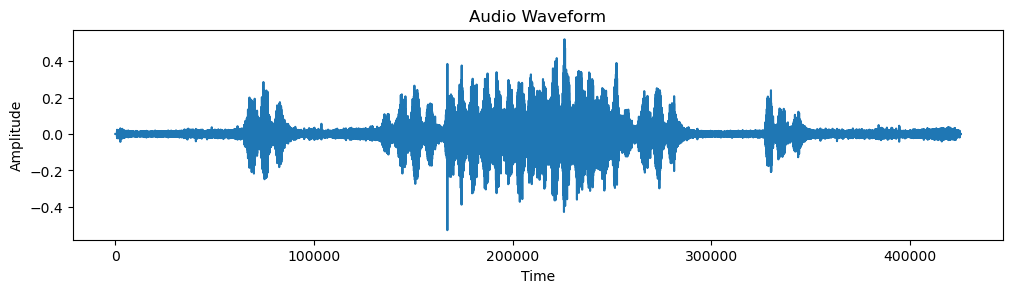

In [243]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)  # 创建两行一列的图形中的第一行
plt.plot(audio_test2[0].numpy())
plt.title('Audio Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')

Text(0, 0.5, 'Amplitude')

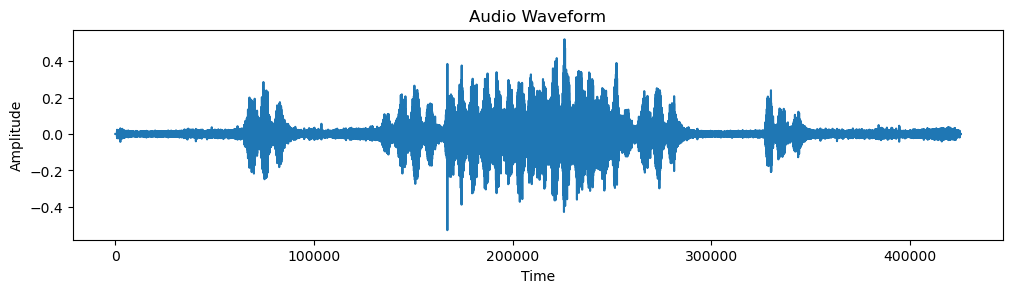

In [244]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)  # 创建两行一列的图形中的第一行
plt.plot(audio_augmentation_test2[0].numpy())
plt.title('Audio Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')

### Because we will use dataloader later, the shape of all data must be consistent each time, but we have not sliced ​​the audio data yet

In [245]:
class BirdclefDataset(Dataset):
    def __init__(self,metadata_path:str,audio_dir:str='../../data/train_audio'):
        '''
        parameters:
            metadata_path: the directory of the metadata csv file
            audio_dir: the parent path where all audio files stored
        '''
        super().__init__()
        self.raw_df=pd.read_csv(metadata_path,header=0)
        # inperplote nan or 0 value of rating col
        self.raw_df=rating_value_interplote(df=self.raw_df)
        # Calculate the weight of each audio file by rating
        self.raw_df=audio_weight(self.raw_df)

        self.audio_dir=audio_dir

    def get_audio_path(self,file_name:str) -> str:
        '''
        Get the audio path of the corresponding index through the provided train metadata csv file. 
        Since there is only one index, only one path will be returned.

        Parameters:
            file_name: in format category_type/XC-ID.ogg (asbfly/XC134896.ogg)

        Return:
            the single audio path string
        '''

        # concatenate parent path and child path
        return os.path.join(self.audio_dir,file_name)


    def target_clip(self,index:int,audio:torch.Tensor,sample_rate:int)->torch.Tensor:
        """
        calculate the index corresponding audio clip 

        information from the train metadata csv

        Parameters:
            audio: the raw audio in tensor [num_channels,length]
            sample_rate: audio sampling rate
        """
        # Get the audio start time corresponding to index
        clip_start_time=self.raw_df['clip_start_time'].iloc[index]
        duration_seconds=self.raw_df['duration'].iloc[index]

        # define clip length
        segment_duration = 5 * sample_rate

        # Total number of samples in the waveform
        total_samples = audio.shape[1]

        if clip_start_time<=duration_seconds:
            clip_start_point=clip_start_time*sample_rate
            # For the last clip, the original audio may not be long enough, so we need to use a mask to fill the sequence
            # The first step is to confirm whether the length is sufficient
            # The length is sufficient, no mask is needed
            if clip_start_point+segment_duration<=total_samples:
                clip=audio[:, clip_start_point:clip_start_point + segment_duration]

            # Not long enough, a mask is needed
            else:
                padding_length = clip_start_point+segment_duration - total_samples
                silence = torch.zeros(audio.shape[0], padding_length)
                # Join the last segment of raw audio with silence
                clip=torch.cat((audio[:,clip_start_point:],silence),dim=1)
                
        else:
            raise ValueError('The clip start time is out of raw audio length')

        return clip


    def random_audio_augmentation(self,audio:torch.Tensor):
        '''
        audio (torch.Tensor): A 2D tensor of audio samples with shape (1, N), where N is the number of samples.
        '''
        np_audio_transforms = CustomCompose(
            [
                CustomOneOf(
                    [
                        NoiseInjection(p=1, max_noise_level=0.04),
                        GaussianNoise(p=1, min_snr=5, max_snr=20),
                        PinkNoise(p=1, min_snr=5, max_snr=20),
                        AddGaussianNoise(min_amplitude=0.0001, max_amplitude=0.03, p=0.5),
                        AddGaussianSNR(min_snr_in_db=5, max_snr_in_db=15, p=0.5),
                    ],
                    p=0.3,  
                ),
            ]
        )

        audio_aug=np_audio_transforms(audio[0].numpy())

        # tranfer the array to 2D tensor and keep the num channel is 1
        # this step is to keep the input and output shape adn type are the same

        audio_aug_tensor=torch.from_numpy(audio_aug)
        audio_aug_tensor=audio_aug_tensor.unsqueeze(0)

        return audio_aug_tensor

    
    def __len__(self):
        return self.raw_df.shape[0]

    def __getitem__(self,index):
        row=self.raw_df.iloc[index]

        audio_label=row['primary_label']
        audio_weight=row['audio_weight']
        # Get the path of a single audio file
        single_audio_dir=self.get_audio_path(row['filename'])

        # Read the audio array according to the path
        audio, sr=read_audio(single_audio_dir)

        # augmentation
        audio_augmentation=self.random_audio_augmentation(audio=audio)

        # Get the audio clip corresponding to index
        clip=self.target_clip(index,audio,sample_rate=sr)

        
        return audio_label,audio,audio_augmentation,audio_weight,clip

In [246]:
BD=BirdclefDataset(metadata_path=metadata_path)

audio_label_test3,audio_test3,audio_augmentation_test3,audio_weights_3,clip3=BD.__getitem__(1)

print(audio_label_test3)
print(audio_test3)
print(audio_test3.shape)
print(audio_augmentation_test3)
print(audio_augmentation_test3.shape)
print(audio_weights_3)
print(clip3)
print(clip3.shape)

malpar1
tensor([[ 4.2087e-07, -5.0013e-07, -6.1193e-06,  ..., -1.7810e-06,
         -2.1815e-06,  3.7659e-06]])
torch.Size([1, 425482])
tensor([[ 0.0225,  0.0233,  0.0058,  ...,  0.0536, -0.0070, -0.0722]])
torch.Size([1, 425482])
1.0
tensor([[ 0.0051,  0.0061, -0.0214,  ...,  0.0072,  0.0065,  0.0038]])
torch.Size([1, 160000])


### define dataloader

In [251]:
class BirdclefDataset(Dataset):
    def __init__(self,metadata_path:str,audio_dir:str='../../data/train_audio'):
        '''
        parameters:
            metadata_path: the directory of the metadata csv file
            audio_dir: the parent path where all audio files stored
        '''
        super().__init__()
        self.raw_df=pd.read_csv(metadata_path,header=0)
        # inperplote nan or 0 value of rating col
        self.raw_df=rating_value_interplote(df=self.raw_df)
        # Calculate the weight of each audio file by rating
        self.raw_df=audio_weight(self.raw_df)

        self.audio_dir=audio_dir

    def get_audio_path(self,file_name:str) -> str:
        '''
        Get the audio path of the corresponding index through the provided train metadata csv file. 
        Since there is only one index, only one path will be returned.

        Parameters:
            file_name: in format category_type/XC-ID.ogg (asbfly/XC134896.ogg)

        Return:
            the single audio path string
        '''

        # concatenate parent path and child path
        return os.path.join(self.audio_dir,file_name)


    def target_clip(self,index:int,audio:torch.Tensor,sample_rate:int)->torch.Tensor:
        """
        calculate the index corresponding audio clip 

        information from the train metadata csv

        Parameters:
            audio: the raw audio in tensor [num_channels,length]
            sample_rate: audio sampling rate
        """
        # Get the audio start time corresponding to index
        clip_start_time=self.raw_df['clip_start_time'].iloc[index]
        duration_seconds=self.raw_df['duration'].iloc[index]

        # define clip length
        segment_duration = 5 * sample_rate

        # Total number of samples in the waveform
        total_samples = audio.shape[1]

        if clip_start_time<=duration_seconds:
            clip_start_point=clip_start_time*sample_rate
            # For the last clip, the original audio may not be long enough, so we need to use a mask to fill the sequence
            # The first step is to confirm whether the length is sufficient
            # The length is sufficient, no mask is needed
            if clip_start_point+segment_duration<=total_samples:
                clip=audio[:, clip_start_point:clip_start_point + segment_duration]

            # Not long enough, a mask is needed
            else:
                padding_length = clip_start_point+segment_duration - total_samples
                silence = torch.zeros(audio.shape[0], padding_length)
                # Join the last segment of raw audio with silence
                clip=torch.cat((audio[:,clip_start_point:],silence),dim=1)
                
        else:
            raise ValueError('The clip start time is out of raw audio length')

        return clip


    def random_audio_augmentation(self,audio:torch.Tensor):
        '''
        audio (torch.Tensor): A 2D tensor of audio samples with shape (1, N), where N is the number of samples.
        '''
        np_audio_transforms = CustomCompose(
            [
                CustomOneOf(
                    [
                        NoiseInjection(p=1, max_noise_level=0.04),
                        GaussianNoise(p=1, min_snr=5, max_snr=20),
                        PinkNoise(p=1, min_snr=5, max_snr=20),
                        AddGaussianNoise(min_amplitude=0.0001, max_amplitude=0.03, p=0.5),
                        AddGaussianSNR(min_snr_in_db=5, max_snr_in_db=15, p=0.5),
                    ],
                    p=0.3,  
                ),
            ]
        )

        audio_aug=np_audio_transforms(audio[0].numpy())

        # tranfer the array to 2D tensor and keep the num channel is 1
        # this step is to keep the input and output shape adn type are the same

        audio_aug_tensor=torch.from_numpy(audio_aug)
        audio_aug_tensor=audio_aug_tensor.unsqueeze(0)

        return audio_aug_tensor

    
    def __len__(self):
        return self.raw_df.shape[0]

    def __getitem__(self,index):
        row=self.raw_df.iloc[index]

        audio_label=row['primary_label']
        audio_weight=row['audio_weight']
        # Get the path to a single audio file
        single_audio_dir=self.get_audio_path(row['filename'])

        # Read audio array according to path
        audio, sr=read_audio(single_audio_dir)

        # augmentation
        audio_augmentation=self.random_audio_augmentation(audio=audio)

        # Get the audio clip corresponding to index
        clip=self.target_clip(index,audio=audio_augmentation,sample_rate=sr)

        
        return audio_label,clip,audio_weight

In [250]:
BD=BirdclefDataset(metadata_path=metadata_path)

train_dataloader = DataLoader(dataset=BD, batch_size=32, sampler=sampler, pin_memory=True)

In [255]:
batch = next(iter(train_dataloader))
audio_label,clip,audio_weights = batch
print(audio_label)
print(type(audio_label))
print(clip)
print(clip.shape)
print(audio_weights)
print(audio_weights.shape)

('putbab1', 'whrmun', 'commyn', 'blnmon1', 'graher1', 'grefla1', 'lesyel1', 'malwoo1', 'barfly1', 'rorpar', 'greegr', 'whbtre1', 'rocpig', 'rewbul', 'comgre', 'forwag1', 'comros', 'comtai1', 'whrmun', 'rufwoo2', 'kenplo1', 'eurcoo', 'scamin3', 'graher1', 'rerswa1', 'blrwar1', 'commoo3', 'thbwar1', 'brcful1', 'forwag1', 'comtai1', 'rewbul')
<class 'tuple'>
tensor([[[ 7.5389e-03, -3.4913e-02, -6.2516e-02,  ..., -3.3997e-03,
          -2.4600e-03, -4.8945e-04]],

        [[-2.3651e-05, -4.6432e-06,  2.6327e-06,  ...,  5.8536e-05,
           1.0246e-04, -5.7879e-05]],

        [[ 7.1145e-02,  7.7600e-02,  5.9140e-02,  ...,  2.9735e-02,
           8.5611e-02,  1.0575e-01]],

        ...,

        [[ 2.0965e-04,  2.4364e-03, -1.2871e-03,  ...,  1.3548e-01,
           3.1768e-02, -9.4112e-02]],

        [[-6.7753e-03, -5.1299e-03, -2.8324e-03,  ..., -6.1314e-03,
          -5.4197e-03, -5.5650e-03]],

        [[ 9.7560e-04,  1.7740e-03,  1.0644e-03,  ...,  9.4651e-05,
           1.7510e-03, -1

In [256]:
bird_cols = [
    "abethr1",
    "abhori1",
    "abythr1",
    "afbfly1",
    "afdfly1",
    "afecuc1",
    "affeag1",
    "afgfly1",
    "afghor1",
    "afmdov1",
    "afpfly1",
    "afpkin1",
    "afpwag1",
    "afrgos1",
    "afrgrp1",
    "afrjac1",
    "afrthr1",
    "amesun2",
    "augbuz1",
    "bagwea1",
    "barswa",
    "bawhor2",
    "bawman1",
    "bcbeat1",
    "beasun2",
    "bkctch1",
    "bkfruw1",
    "blacra1",
    "blacuc1",
    "blakit1",
    "blaplo1",
    "blbpuf2",
    "blcapa2",
    "blfbus1",
    "blhgon1",
    "blhher1",
    "blksaw1",
    "blnmou1",
    "blnwea1",
    "bltapa1",
    "bltbar1",
    "bltori1",
    "blwlap1",
    "brcale1",
    "brcsta1",
    "brctch1",
    "brcwea1",
    "brican1",
    "brobab1",
    "broman1",
    "brosun1",
    "brrwhe3",
    "brtcha1",
    "brubru1",
    "brwwar1",
    "bswdov1",
    "btweye2",
    "bubwar2",
    "butapa1",
    "cabgre1",
    "carcha1",
    "carwoo1",
    "categr",
    "ccbeat1",
    "chespa1",
    "chewea1",
    "chibat1",
    "chtapa3",
    "chucis1",
    "cibwar1",
    "cohmar1",
    "colsun2",
    "combul2",
    "combuz1",
    "comsan",
    "crefra2",
    "crheag1",
    "crohor1",
    "darbar1",
    "darter3",
    "didcuc1",
    "dotbar1",
    "dutdov1",
    "easmog1",
    "eaywag1",
    "edcsun3",
    "egygoo",
    "equaka1",
    "eswdov1",
    "eubeat1",
    "fatrav1",
    "fatwid1",
    "fislov1",
    "fotdro5",
    "gabgos2",
    "gargan",
    "gbesta1",
    "gnbcam2",
    "gnhsun1",
    "gobbun1",
    "gobsta5",
    "gobwea1",
    "golher1",
    "grbcam1",
    "grccra1",
    "grecor",
    "greegr",
    "grewoo2",
    "grwpyt1",
    "gryapa1",
    "grywrw1",
    "gybfis1",
    "gycwar3",
    "gyhbus1",
    "gyhkin1",
    "gyhneg1",
    "gyhspa1",
    "gytbar1",
    "hadibi1",
    "hamerk1",
    "hartur1",
    "helgui",
    "hipbab1",
    "hoopoe",
    "huncis1",
    "hunsun2",
    "joygre1",
    "kerspa2",
    "klacuc1",
    "kvbsun1",
    "laudov1",
    "lawgol",
    "lesmaw1",
    "lessts1",
    "libeat1",
    "litegr",
    "litswi1",
    "litwea1",
    "loceag1",
    "lotcor1",
    "lotlap1",
    "luebus1",
    "mabeat1",
    "macshr1",
    "malkin1",
    "marsto1",
    "marsun2",
    "mcptit1",
    "meypar1",
    "moccha1",
    "mouwag1",
    "ndcsun2",
    "nobfly1",
    "norbro1",
    "norcro1",
    "norfis1",
    "norpuf1",
    "nubwoo1",
    "pabspa1",
    "palfly2",
    "palpri1",
    "piecro1",
    "piekin1",
    "pitwhy",
    "purgre2",
    "pygbat1",
    "quailf1",
    "ratcis1",
    "raybar1",
    "rbsrob1",
    "rebfir2",
    "rebhor1",
    "reboxp1",
    "reccor",
    "reccuc1",
    "reedov1",
    "refbar2",
    "refcro1",
    "reftin1",
    "refwar2",
    "rehblu1",
    "rehwea1",
    "reisee2",
    "rerswa1",
    "rewsta1",
    "rindov",
    "rocmar2",
    "rostur1",
    "ruegls1",
    "rufcha2",
    "sacibi2",
    "sccsun2",
    "scrcha1",
    "scthon1",
    "shesta1",
    "sichor1",
    "sincis1",
    "slbgre1",
    "slcbou1",
    "sltnig1",
    "sobfly1",
    "somgre1",
    "somtit4",
    "soucit1",
    "soufis1",
    "spemou2",
    "spepig1",
    "spewea1",
    "spfbar1",
    "spfwea1",
    "spmthr1",
    "spwlap1",
    "squher1",
    "strher",
    "strsee1",
    "stusta1",
    "subbus1",
    "supsta1",
    "tacsun1",
    "tafpri1",
    "tamdov1",
    "thrnig1",
    "trobou1",
    "varsun2",
    "vibsta2",
    "vilwea1",
    "vimwea1",
    "walsta1",
    "wbgbir1",
    "wbrcha2",
    "wbswea1",
    "wfbeat1",
    "whbcan1",
    "whbcou1",
    "whbcro2",
    "whbtit5",
    "whbwea1",
    "whbwhe3",
    "whcpri2",
    "whctur2",
    "wheslf1",
    "whhsaw1",
    "whihel1",
    "whrshr1",
    "witswa1",
    "wlwwar",
    "wookin1",
    "woosan",
    "wtbeat1",
    "yebapa1",
    "yebbar1",
    "yebduc1",
    "yebere1",
    "yebgre1",
    "yebsto1",
    "yeccan1",
    "yefcan",
    "yelbis1",
    "yenspu1",
    "yertin1",
    "yesbar1",
    "yespet1",
    "yetgre1",
    "yewgre1",
]

In [269]:
labels = np.zeros(shape=(10,len(bird_cols)))

print(labels)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [271]:
df_labels = pd.DataFrame(labels,columns=bird_cols)

display(df_labels)

,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,afmdov1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [272]:
df_labels.loc[0,'abethr1']=1

display(df_labels)

,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,afmdov1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [276]:
a=df_labels.loc[0].values

In [280]:
b=torch.tensor(a).float()

b.shape

torch.Size([264])

In [278]:
Y = torch.clamp(b, 0, 0.1)

In [279]:
Y

tensor([0.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [257]:
class_sample_count = {col:0 for col in bird_cols}

In [259]:
class_sample_count

{'abethr1': 0,
 'abhori1': 0,
 'abythr1': 0,
 'afbfly1': 0,
 'afdfly1': 0,
 'afecuc1': 0,
 'affeag1': 0,
 'afgfly1': 0,
 'afghor1': 0,
 'afmdov1': 0,
 'afpfly1': 0,
 'afpkin1': 0,
 'afpwag1': 0,
 'afrgos1': 0,
 'afrgrp1': 0,
 'afrjac1': 0,
 'afrthr1': 0,
 'amesun2': 0,
 'augbuz1': 0,
 'bagwea1': 0,
 'barswa': 0,
 'bawhor2': 0,
 'bawman1': 0,
 'bcbeat1': 0,
 'beasun2': 0,
 'bkctch1': 0,
 'bkfruw1': 0,
 'blacra1': 0,
 'blacuc1': 0,
 'blakit1': 0,
 'blaplo1': 0,
 'blbpuf2': 0,
 'blcapa2': 0,
 'blfbus1': 0,
 'blhgon1': 0,
 'blhher1': 0,
 'blksaw1': 0,
 'blnmou1': 0,
 'blnwea1': 0,
 'bltapa1': 0,
 'bltbar1': 0,
 'bltori1': 0,
 'blwlap1': 0,
 'brcale1': 0,
 'brcsta1': 0,
 'brctch1': 0,
 'brcwea1': 0,
 'brican1': 0,
 'brobab1': 0,
 'broman1': 0,
 'brosun1': 0,
 'brrwhe3': 0,
 'brtcha1': 0,
 'brubru1': 0,
 'brwwar1': 0,
 'bswdov1': 0,
 'btweye2': 0,
 'bubwar2': 0,
 'butapa1': 0,
 'cabgre1': 0,
 'carcha1': 0,
 'carwoo1': 0,
 'categr': 0,
 'ccbeat1': 0,
 'chespa1': 0,
 'chewea1': 0,
 'chibat1': 

In [260]:
perm = torch.randperm(32)

In [261]:
perm

tensor([29,  1, 13, 26, 20, 23,  0, 24, 10,  3, 14, 12, 30, 22, 21, 27, 19,  6,
        25, 17,  9, 16,  2, 28, 11, 18,  8,  7, 15,  5, 31,  4])

In [264]:
clip

tensor([[[ 7.5389e-03, -3.4913e-02, -6.2516e-02,  ..., -3.3997e-03,
          -2.4600e-03, -4.8945e-04]],

        [[-2.3651e-05, -4.6432e-06,  2.6327e-06,  ...,  5.8536e-05,
           1.0246e-04, -5.7879e-05]],

        [[ 7.1145e-02,  7.7600e-02,  5.9140e-02,  ...,  2.9735e-02,
           8.5611e-02,  1.0575e-01]],

        ...,

        [[ 2.0965e-04,  2.4364e-03, -1.2871e-03,  ...,  1.3548e-01,
           3.1768e-02, -9.4112e-02]],

        [[-6.7753e-03, -5.1299e-03, -2.8324e-03,  ..., -6.1314e-03,
          -5.4197e-03, -5.5650e-03]],

        [[ 9.7560e-04,  1.7740e-03,  1.0644e-03,  ...,  9.4651e-05,
           1.7510e-03, -1.3493e-03]]])

In [265]:
clip2=clip+clip[perm]

In [267]:
clip2.shape

torch.Size([32, 1, 160000])

In [268]:
clip2

tensor([[[ 7.7485e-03, -3.2477e-02, -6.3803e-02,  ...,  1.3208e-01,
           2.9308e-02, -9.4601e-02]],

        [[-4.7301e-05, -9.2865e-06,  5.2655e-06,  ...,  1.1707e-04,
           2.0493e-04, -1.1576e-04]],

        [[ 6.9268e-02,  7.6486e-02,  5.8410e-02,  ...,  2.9735e-02,
           8.5611e-02,  1.0575e-01]],

        ...,

        [[ 5.4392e-02,  4.2804e-02,  5.7297e-02,  ...,  1.5878e-01,
           4.9138e-02, -6.5375e-02]],

        [[-5.7997e-03, -3.3559e-03, -1.7680e-03,  ..., -6.0368e-03,
          -3.6687e-03, -6.9143e-03]],

        [[ 9.8036e-04,  1.7729e-03,  1.0698e-03,  ..., -6.5927e-04,
           1.0055e-03, -2.2466e-03]]])